# EX-10 Translator seq2seq

### 곽상혁

### 2022-12-09 (금)

https://github.com/docosa2/

## 모듈 임포트

In [453]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd

print(tf.__version__)

2.6.0


실습에서 구현한 번역기는 글자 단위(Character-level)에서 구현된 번역기였습니다. 하지만 실제 번역기의 경우에는 글자 단위가 아니라 단어 단위(Word-level)에서 구현되는 것이 좀 더 보편적입니다.

동일한 데이터셋을 사용하면서 글자 단위와는 다른 전처리와 to_categorical() 함수가 아닌 임베딩 층(Embedding layer)를 추가하여 단어 단위의 번역기를 완성시켜보겠습니다. 하지만, 단어 단위로 할 경우에는 단어의 개수가 글자 단위로 했을 경우와 비교하여 단어장의 크기(Vocabulary) 크기도 커지고, 학습 속도도 좀 더 느려집니다. 학습과 테스트 시의 원활한 진행을 위해서 데이터에서 상위 33,000개의 샘플만 사용해주세요.

33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용합니다.

### 데이타 파일 읽어오기

In [454]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
67377,Tom bought Mary a scarf.,Tom a acheté une écharpe pour Marie.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
88376,I wish he were on our team.,J'aimerais qu'il fasse partie de notre équipe.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
180825,I promised to help my brother with his homework.,J'ai promis d'aider mon frère avec ses devoirs.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
34467,Bring them with you.,Apportez-les avec vous.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
74433,That's not really my job.,Ce n'est pas vraiment mon travail.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...


### 중복 제거

In [455]:
lines = lines.drop_duplicates(subset='eng')
print('중복 제거 후 전체 샘플의 수 :',len(lines))

중복 제거 후 전체 샘플의 수 : 138912


### 불필요한 칼럼 제거

In [456]:
lines = lines[['eng', 'fra']][-36000:].reset_index(drop=True)

In [457]:
lines

,eng,fra
0,I'm the one who picked those flowers.,C'est moi-même qui ai cueilli ces fleurs.
1,I'm the one who should be doing that.,Je suis celui qui devrait être en train de fai...
2,I'm the one who should be doing this.,C'est moi qui devrais faire ceci.
3,I'm the only one planning to do that.,Je ne suis pas le seul à prévoir de le faire.
4,I'm the only one who understands Tom.,Je suis le seul qui comprend Tom.
...,...,...
35995,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
35996,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
35997,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
35998,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...


### 셔플

In [458]:
lines = lines.iloc[np.random.permutation(lines.index)].reset_index(drop=True)

In [459]:
lines

,eng,fra
0,"Apparently, the murder happened in a locked room.","Apparemment, le meurtre a eu lieu en chambre c..."
1,My cat likes to look through the window.,Mon chat aime regarder par la fenêtre.
2,This is the dictionary I use every day.,C'est le dictionnaire que j'utilise tous les j...
3,I want an hourly update about what's happening.,Je veux être tenu au courant de ce qui se pass...
4,"You'll get half the money now, and the other h...",Vous recevrez la moitié de l'argent maintenant...
...,...,...
35995,"Next time, ask me before you use my car.","La prochaine fois, demande-moi avant de te ser..."
35996,I don't think you did this by yourself.,Je ne pense pas que tu aies fait ceci par toi-...
35997,"You haven't seen Tom today, have you?","Vous n'avez pas vu Tom aujourd'hui, n'est-ce p..."
35998,She was the most beautiful woman he had ever s...,Elle était la plus belle femme qu'il avait jam...


### Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)
---

글자 단위가 아닌 단어 단위의 번역기를 하기 위해서는 글자 단위에서는 신경쓰지 않았던 몇 가지 추가적인 전처리가 필요합니다.

1. 구두점(Punctuation)을 단어와 분리해주세요.

일반적으로 영어권 언어의 경우에는 띄어쓰기 단위로 단어를 분리합니다. 토큰화(Tokenization) 라고도 불리는 이 작업은 어디서부터 어디까지가 하나의 단어인지를 구분하는 작업인데요, 그런데 띄어쓰기를 해주기 전에 구두점을 분리하는 작업이 필요할 때가 있습니다.
예를 들어서 'he is a good boy!'라는 문장이 있을 때, 이를 띄어쓰기 단위로 토큰화한다면 ['he', 'is', 'a', 'good', 'boy!']가 됩니다. 그런데 실제로 !는 boy와 붙어있는 한 단어가 아니므로 좀 더 올바른 전처리는 ['he', 'is', 'a', 'good', 'boy', '!']가 맞습니다.
!나 ? 또는 온점과 같은 특수문자들을 구두점(punctuation)이라고 부릅니다. 이들을 토큰화하기 전에 단어와 미리 분리시켜주세요!

> 분리 전 : he is a Good boy!  
> 분리 후 : he is a Good boy !

In [460]:
import re

def Seperate_punctuations(sentence: str) -> str:
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
    return sentence

In [461]:
assert Seperate_punctuations('This Is, So To Speak, A Kind Of A Test Sentence.') == ('This Is ,  So To Speak ,  A Kind Of A Test Sentence . '), 'Error in converter to seperate punctuations.'

In [462]:
def Sepearate_entire_punctuations_for(df: pd.DataFrame) -> None:
    for index, row in df.iterrows():
        row['eng'] = Seperate_punctuations(row['eng'])
        row['fra'] = Seperate_punctuations(row['fra'])

In [463]:
Sepearate_entire_punctuations_for(lines)

In [464]:
lines.head()

,eng,fra
0,"Apparently , the murder happened in a locked ...","Apparemment , le meurtre a eu lieu en chambre..."
1,My cat likes to look through the window .,Mon chat aime regarder par la fenêtre .
2,This is the dictionary I use every day .,C'est le dictionnaire que j'utilise tous les j...
3,I want an hourly update about what's happening .,Je veux être tenu au courant de ce qui se pass...
4,"You'll get half the money now , and the other...",Vous recevrez la moitié de l'argent maintenant...


2. 소문자로 바꿔주세요.

기계가 보기에는 스펠링이 같더라도 대문자로 된 단어와 소문자로 된 단어는 서로 다른 단어입니다. 예를 들어 'Good'과 'good'은 기계가 보기에는 다른 단어입니다. 그래서 모든 문장에 대해서 전부 영어로 바꿔주는 작업을 하겠습니다.

> 변환 전 : he is a Good boy !  
> 변환 후 : he is a good boy !

In [465]:
import re

def Convert_to_lower_case(sentence: str) -> str:
    sentence = sentence.lower().strip()
    return sentence

In [466]:
assert Convert_to_lower_case('This Is A Test Sentence.') == ('this is a test sentence.'), 'Error in converter for lower case.'

In [467]:
def Convert_to_lower_cases_for(df: pd.DataFrame) -> None:
    for index, row in df.iterrows():
        row['eng'] = Convert_to_lower_case(row['eng'])
        row['fra'] = Convert_to_lower_case(row['fra'])

In [468]:
Convert_to_lower_cases_for(lines)

In [469]:
lines.head()

,eng,fra
0,"apparently , the murder happened in a locked ...","apparemment , le meurtre a eu lieu en chambre..."
1,my cat likes to look through the window .,mon chat aime regarder par la fenêtre .
2,this is the dictionary i use every day .,c'est le dictionnaire que j'utilise tous les j...
3,i want an hourly update about what's happening .,je veux être tenu au courant de ce qui se pass...
4,"you'll get half the money now , and the other...",vous recevrez la moitié de l'argent maintenant...


### 디코더에 시작토큰과 종료 토큰 삽입

In [470]:
sos_token = 'sostoken'
eos_token = 'eostoken'
lines.fra = lines.fra.apply(lambda x : 'sostoken '+ x + ' eostoken')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 36000


,eng,fra
33861,i make it a rule never to borrow money .,sostoken j'ai érigé en règle de ne jamais empr...
23961,certain details of the crime were not made pub...,sostoken certains détails du crime n'ont pas é...
27491,the two pieces were glued tightly together .,sostoken les deux morceaux furent fermement co...
35947,i need you to help me move this bookcase .,sostoken j'ai besoin que tu m'aides à déplacer...
17084,this isn't the first time this has happened .,sostoken ce n'est pas la première fois que ça ...


3. 띄어쓰기 단위로 토큰화를 수행하세요.

띄어쓰기 단위로 토큰화를 수행해서 단어를 분리하는 작업을 해주세요. 기계는 이렇게 분리된 토큰들을 각각 하나의 단어로 인식할 수 있게 됩니다.

> 토큰화 전 : 'he is a good boy !'  
> 토큰화 후 : ['he', 'is', 'a', 'good', 'boy', '!']

In [471]:
def Tokenize_by_word(sentence: str) -> list:
    return sentence.split()

In [472]:
assert Tokenize_by_word('he is a good boy !') == ['he', 'is', 'a', 'good', 'boy', '!'], 'word tokenizer error.'

In [473]:
def Tokenize_by_word_for(df: pd.DataFrame) -> (list, list): # english, french
    encode_sentences = []
    decode_sentences = []
    for index, row in df.iterrows():
        encode_tokens = Tokenize_by_word(row['eng'])
        decode_tokens = Tokenize_by_word(row['fra'])
        encode_sentences.append(encode_tokens)
        decode_sentences.append(decode_tokens)
    return encode_sentences, decode_sentences

In [474]:
english_corpus, french_corpus = Tokenize_by_word_for(lines)

### Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.
---

글자 단위 번역기를 구현할 때와 마찬가지로 디코더의 입력 시퀀스 맨 앞에는 시작을 의미하는 토큰인 <sos>가 필요합니다. 그리고 교사 강요를 수행할 때, 디코더의 실제값이 되는 디코더의 레이블 시퀀스에는 종료를 의미하는 종료 토큰 <eos>가 필요합니다.
예를 들어 번역 문장이 "Courez!" 였다고 한다면, Step 1을 거친 후에는 다음과 같은 결과를 얻습니다.

> Step 1을 수행한 후 : ['courez', '!']

In [475]:
english_corpus[0]

['apparently',
 ',',
 'the',
 'murder',
 'happened',
 'in',
 'a',
 'locked',
 'room',
 '.']

이 문장에 대해서 각각 디코더의 입력 시퀀스와 레이블 시퀀스를 만들면 다음과 같습니다.

> 입력 시퀀스 : ['< sos >', 'courez', '!']  
> 레이블 시퀀스 : ['courez', '!', '< eos >']

In [476]:
french_corpus[0]

['sostoken',
 'apparemment',
 ',',
 'le',
 'meurtre',
 'a',
 'eu',
 'lieu',
 'en',
 'chambre',
 'close',
 '.',
 'eostoken']

참고로 Step 2가 반드시 Step 1이 끝난 후에 이루어질 필요는 없습니다!  
Step 1을 수행하는 중간에 수행해도 상관없습니다.

### Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.
---

딥러닝 모델은 텍스트가 아닌 숫자를 처리합니다. 케라스 토크나이저를 사용해서 각 단어를 고유한 정수로 바꿔보세요.
케라스 토크나이저의 사용법은 아래의 링크에서 2. 케라스(Keras)의 텍스트 전처리에 설명되어 있습니다.

[위키독스](https://wikidocs.net/31766)  

위 링크의 가이드를 통해서 영어와 프랑스어에 대한 토크나이저를 각각 생성하고, tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로 변환해보세요.

In [477]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [478]:
def tokenize(corpus):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)        
    return tensor, tokenizer

In [479]:
english_text, english_tokenizer = tokenize(english_corpus)
french_text, french_tokenizer = tokenize(french_corpus)

In [480]:
english_text[:3]

[[3254, 8, 2, 1196, 219, 9, 6, 1295, 170, 1],
 [20, 608, 653, 3, 216, 372, 2, 472, 1],
 [18, 11, 2, 623, 4, 253, 127, 98, 1]]

In [481]:
french_text[:3]

[[1, 3008, 11, 9, 1376, 18, 143, 417, 23, 337, 10197, 3, 2],
 [1, 43, 648, 649, 437, 61, 6, 484, 3, 2],
 [1, 52, 9, 642, 7, 3683, 83, 17, 172, 3, 2]]

####  인코딩 상태 확인

In [482]:
print('영어 문장수', len(english_text))
print('프랑스어 문장수', len(french_text))

영어 문장수 36000
프랑스어 문장수 36000


In [483]:
english_vocab_size = len(english_tokenizer.word_index) + 1
french_vocab_size = len(french_tokenizer.word_index) + 1
print('영어 단어수:', english_vocab_size)
print('프랑스어 단어수:', french_vocab_size)

영어 단어수: 12246
프랑스어 단어수: 19259


In [484]:
max_eng_len = max([len(s) for s in english_text])
max_fre_len = max([len(s) for s in french_text])
print('영어 문장 최대 길이 :', max_eng_len)
print('프랑스 문장 최대 길이 :', max_fre_len)

영어 문장 최대 길이 : 51
프랑스 문장 최대 길이 : 61


### Step 4. 임베딩 층(Embedding layer) 사용하기

이번에는 입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화하겠습니다.
임베딩 층을 사용하는 방법과 그 설명에 대해서는 아래의 링크의 1. 케라스 임베딩 층(Keras Embedding layer) 을 참고하세요.

[위키독스](https://wikidocs.net/33793)

실제 번역기 구현을 위해서 사용할 수 있는 인코더 코드의 예시는 다음과 같습니다. 이를 통해서 인코더와 디코더의 임베딩 층을 각각 구현해보세요.

In [485]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [486]:
len(french_text)

36000

In [487]:
encoder_input = english_text
decoder_input = [sentence[:-1] for sentence in french_text]
decoder_target = [sentence[1:] for sentence in french_text]

In [488]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fre_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fre_len, padding='post')
print('영어 데이타 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력 데이타 크기(shape) :',np.shape(decoder_input))
print('프랑스어 타겟 데이타 크기(shape) :',np.shape(decoder_target))

영어 데이타 크기(shape) : (36000, 51)
프랑스어 입력 데이타 크기(shape) : (36000, 61)
프랑스어 타겟 데이타 크기(shape) : (36000, 61)


In [489]:
test_num = 3000
val_num = 3000

encoder_input_train = encoder_input[:-6000]
decoder_input_train = decoder_input[:-6000]
decoder_target_train = decoder_target[:-6000]

encoder_input_val = encoder_input[-6000:-3000]
decoder_input_val = decoder_input[-6000:-3000]
decoder_target_val = decoder_target[-6000:-3000]

encoder_input_test = encoder_input[-3000:]
decoder_input_test = decoder_input[-3000:]
decoder_target_test = decoder_target[-3000:]


print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))
print()
print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_val))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_val))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_val))
print()
print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_test))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_test))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_test))

영어 학습데이터의 크기(shape) : (30000, 51)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 61)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 61)

영어 학습데이터의 크기(shape) : (3000, 51)
프랑스어 학습 입력데이터의 크기(shape) : (3000, 61)
프랑스어 학습 출력데이터의 크기(shape) : (3000, 61)

영어 학습데이터의 크기(shape) : (3000, 51)
프랑스어 학습 입력데이터의 크기(shape) : (3000, 61)
프랑스어 학습 출력데이터의 크기(shape) : (3000, 61)


In [490]:
print(encoder_input_train[0])

[3254    8    2 1196  219    9    6 1295  170    1    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


#### 인코더

In [491]:
# 입력 텐서 정의 및 생성.
eng_vocab_size = english_vocab_size
fra_vocab_size = french_vocab_size

# 인코더 시작
embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(None,))
enc_emb_layer =  Embedding(eng_vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(units=256, return_state=True, dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb_layer)
encoder_states = [state_h, state_c]

#### 디코더

In [492]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(fra_vocab_size, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs) 
decoder_lstm = LSTM(256, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

#### 출력층

In [493]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

### Step 5. 모델 구현하기
---

글자 단위 번역기에서 구현한 모델을 참고로 단어 단위 번역기의 모델을 완성시켜보세요! 이때는 label이 integer 값이므로 categorical entropy loss가 아닌 sparse categorical entropy loss를 사용합니다.

In [494]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [495]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

In [496]:
model.summary()

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, None, 128)    1567488     input_38[0][0]                   
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, None, 128)    2465152     input_39[0][0]                   
___________________________________________________________________________________________

### 모델 훈련하기

In [497]:
decoder_target_train.shape

(30000, 61)

In [498]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_val, decoder_input_val], decoder_target_val), 
          batch_size=512, epochs=30)

Epoch 1/30
59/59 [==============================] - 32s 500ms/step - loss: 3.4110 - val_loss: 1.3408
Epoch 2/30
59/59 [==============================] - 29s 489ms/step - loss: 1.2953 - val_loss: 1.2929
Epoch 3/30
59/59 [==============================] - 29s 484ms/step - loss: 1.2482 - val_loss: 1.2332
Epoch 4/30
59/59 [==============================] - 29s 489ms/step - loss: 1.1806 - val_loss: 1.1739
Epoch 5/30
59/59 [==============================] - 29s 486ms/step - loss: 1.1348 - val_loss: 1.1351
Epoch 6/30
59/59 [==============================] - 29s 488ms/step - loss: 1.0987 - val_loss: 1.1016
Epoch 7/30
59/59 [==============================] - 29s 491ms/step - loss: 1.0650 - val_loss: 1.0746
Epoch 8/30
59/59 [==============================] - 29s 488ms/step - loss: 1.0375 - val_loss: 1.0511
Epoch 9/30
59/59 [==============================] - 29s 491ms/step - loss: 1.0128 - val_loss: 1.0311
Epoch 10/30
59/59 [==============================] - 29s 494ms/step - loss: 0.9912 - val_lo

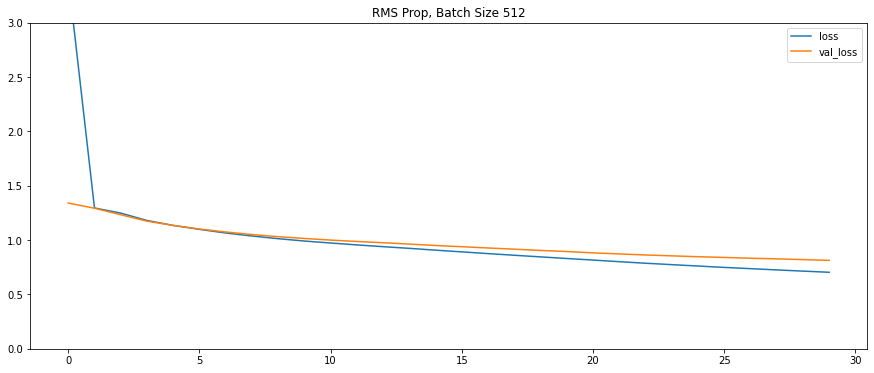

In [506]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,6))

for k,v in history.history.items():
    plt.plot(history.history[k], label=k)
plt.ylim(0, 3)
plt.title('RMS Prop, Batch Size 512')
plt.legend()

### Step 6. 모델 평가하기
---
단어 단위 번역기를 이용하여 훈련 데이터의 샘플과 테스트 데이터의 샘플로 번역 문장을 만들어보고 정답 문장과 번역 문장을 비교해보세요. 이전 스텝들에서 우리가 공부했던 모델의 경우 글자 단위에서 구현된 번역기이며 현재 프로젝트를 진행할 때 사용하는 모델은 단어 단위에서 구현되는 번역기입니다.

> Embedding layer가 추가되기 때문에 학습했던 내용 그대로 사용할 경우 shape에서 error가 발생합니다.
> decode sentence를 구성할 때 고민해보세요!!

고민하다 풀리지 않을 경우에는 하단 내용 참고해주세요.

In [500]:
eng2idx = english_tokenizer.word_index
fra2idx = french_tokenizer.word_index
idx2eng = english_tokenizer.index_word
idx2fra = french_tokenizer.index_word

In [501]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
hidden_size = 256
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

### 번역기 작성

In [502]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
    states_value = encoder_model.predict(input_seq)

    # <sos>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx['sostoken']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if (sampled_token_index > 0):            
            sampled_char = idx2fra[sampled_token_index]
            # 현재 시점의 예측 단어를 예측 문장에 추가
            decoded_sentence += ' '+sampled_char

        # eos에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_token_index == 0 or
            sampled_char == 'eostoken' or 
            len(decoded_sentence) > 30):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [503]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if(encoded_word != 0):
            sentence = sentence + idx2eng[encoded_word] + ' '
    return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if(encoded_word != 0 and encoded_word != fra2idx['sostoken'] and encoded_word != fra2idx['eostoken']):
            sentence = sentence + idx2fra[encoded_word] + ' '
    return sentence

In [504]:
for seq_index in [1, 10, 20, 30, 100, 200, 1000, 2000, 2500]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

입력문장 : he doesn't have the necessary skills for that job . 
정답문장 : il ne dispose pas des compétences nécessaires à cet emploi . 
번역문장 : tom a dit qu'il est un peu de 
--------------------------------------------------
입력문장 : he carved a buddhist image out of wood . 
정답문장 : il a sculpté une image bouddhiste dans du bois . 
번역문장 : il a été de temps pour le
--------------------------------------------------
입력문장 : i asked her to marry me and she accepted . 
정답문장 : je lui demandai de m'épouser et elle accepta . 
번역문장 : je suis désolé de la maison ,
--------------------------------------------------
입력문장 : i am not used to drinking coffee without sugar . 
정답문장 : je ne suis pas habitué à boire du café sans sucre . 
번역문장 : je ne peux pas être en tra
--------------------------------------------------
입력문장 : i am going to study english this afternoon . 
정답문장 : je vais étudier l'anglais cet après-midi . 
번역문장 : je suis allé à boston pour la m
--------------------------------------------------
입력

루브릭  
아래의 기준을 바탕으로 프로젝트를 평가합니다.  
평가문항	상세기준

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.  
구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.  

2. seq2seq 기반의 번역기 모델이 정상적으로 구동된다.  
seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행됨이 확인되었다.

3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.  
테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인하였다.


### 고찰
1. 단어 단위 임베딩에 따른 인풋 벡터의 변화에 대한 이해가 어려웠다.
2. 중복되는 문장이 있어 이를 제거하니  val loss가 약간 더 줄어드는 것처럼 보였다. 전처리와 데이타를 살펴보는 과정이 중요하다.
3. 모델 학습에 소요되는 시간이 길어 여러가지 실험을 해보지 못한 점이 아쉬웠다.
4. 모델 학습 시 오류가 발생해서 디버깅에 시간을 보냈다. 오류가 생긴 이유는 로스 함수의 선택이 잘못되었기 때문이었다. 입력 벡터의 차원이 맞지 않는다는 오류메세지가 나올 때도 원인은 엉뚱한 곳에서 나올 수 있으므로 기본적인 사항들을 모두 확인해야 한다는 점을 알았다.